<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/agrinet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgrifieldNet India Competition

## Install and import dependencies


In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
rasterio==1.2.0
numpy==1.21.6
radiant_mlhub==0.4.1
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2
pillow==7.1.2
monai==0.9.1

Writing requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 7.2 MB/s 
     |████████████████████████████████| 19.1 MB 442 kB/s 
     |████████████████████████████████| 990 kB 48.6 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 146 kB 61.5 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import os
import time
import json
import getpass
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
from radiant_mlhub import Dataset
import tarfile
import shutil
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn
from skimage import io
from torchvision import transforms as torch_transforms
from torchvision import models
import pylab as plt
from PIL import Image
from skimage.segmentation import mark_boundaries
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceCELoss, MaskedDiceLoss
from monai.metrics import DiceMetric
from google.colab import drive

## Specify global parameters

In [4]:
drive.mount('/content/gdrive')
path = 'gdrive/MyDrive/Colab Notebooks/'

Mounted at /content/gdrive


In [5]:
random_seed = 42

train_df_path = 'train_data.csv'

BAND_NAMES = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 'B08','B8A', 'B09', 'B11', 'B12']
# BAND_NAMES = ['B02', 'B03', 'B04', 'B08']

In [6]:
np.random.seed(random_seed)

## Download data from MLHUB


In [7]:
collection_name = 'ref_agrifieldnet_competition_v1'
data_dir = 'data'
# data_dir = path + collection_name

source_collection = f'{collection_name}_source'
train_label_collection = f'{collection_name}_labels_train'
test_label_collection = f'{collection_name}_labels_test'

In [8]:
if not os.path.exists(data_dir):
  os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")

  dataset = Dataset.fetch(collection_name)
  dataset.download(output_dir=data_dir)
  for fn in os.listdir(data_dir):
    with tarfile.open(os.path.join(data_dir, fn)) as f:
      f.extractall(data_dir + '/') 
    os.remove(os.path.join(data_dir, fn))
else:
  print("Dataset already exists")

MLHub API Key: ··········


  0%|          | 0/0.5 [00:00<?, ?M/s]

  0%|          | 0/324.3 [00:00<?, ?M/s]

  0%|          | 0/1.3 [00:00<?, ?M/s]

## Prepare Training data


### Create training dataframe

In [9]:
train_paths = os.listdir(os.path.join(data_dir, train_label_collection))
train_ids = [fn.split('_')[-1] for fn in train_paths if 'labels_train' in fn]

field_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/field_ids.tif' 
               for i in train_ids]
label_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/raster_labels.tif' 
               for i in train_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in train_ids]

In [10]:
train_data = pd.DataFrame(np.array([train_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
train_data.head()

,folder_id,field_path,label_path,source_path
0,7145a,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
1,a846e,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
2,c623b,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
3,4b31d,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
4,e4ad1,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...


## Extract band mean and std

In [11]:
source_paths = [fn for fn in os.listdir(os.path.join(data_dir, 
                                                     source_collection)) 
if not fn.endswith('json')]

In [12]:
means = []
stds = []
for source_path in tqdm(source_paths):
  m = []
  s = []
  for band in BAND_NAMES:
    with rasterio.open(os.path.join(data_dir, source_collection, source_path) + rf"/{band}.tif") as src:
      img = src.read()[0]
      m.append(np.mean(img))
      s.append(np.std(img))
  means.append(m)
  stds.append(s)
means = np.array(means).mean(0)
stds = np.array(stds).mean(0)

100%|██████████| 1217/1217 [00:50<00:00, 24.24it/s]



## Extract field-crop data

In [13]:
def extract_field_crop_data(data):
  field_ids = []
  crop_type = []
  field_area = []
  field_max_dim = []
  field_center_x = []
  field_center_y = []
  label_paths = []
  field_paths = []
  source_paths = []

  for i in tqdm(range(len(data))):
      with rasterio.open(data['field_path'].iloc[i]) as src:
          field_data = src.read()[0]
      with rasterio.open(data['label_path'].iloc[i]) as src:
          crop_data = src.read()[0]

      for field_id in np.unique(field_data)[1:]:
          ind = np.where(field_data == field_id)
          field_ids.append(field_id)
          crop_type.append(np.unique(crop_data[ind])[-1])
          field_area.append(len(ind[0]))
          field_max_dim.append(np.max(np.array(ind).max(1) - np.array(ind).min(1) + 1))
          field_center_y.append(np.mean(ind[0]))
          field_center_x.append(np.mean(ind[1]))
          label_paths.append(data['label_path'].iloc[i])
          field_paths.append(data['field_path'].iloc[i])
          source_paths.append(data['source_path'].iloc[i])

  df = pd.DataFrame(np.array([field_ids, crop_type, field_area, 
                              field_max_dim, field_center_x, 
                              field_center_y]).transpose(),
                    columns=['field_id', 'crop_type', 'field_area', 
                            'field_max_dim', 'center_x', 'center_y'])
  df['label_path'] = label_paths
  df['field_path'] = field_paths
  df['source_path'] = source_paths
  return df

In [14]:
df = extract_field_crop_data(train_data)

100%|██████████| 1165/1165 [00:07<00:00, 158.08it/s]


In [15]:
crop_labels = np.unique(df['crop_type'])
df['crop_ind'] = df['crop_type'].apply(lambda x: np.where(crop_labels == x)[0][0])

In [16]:
(df['crop_type'] == crop_labels[df['crop_ind']]).unique()

array([ True])

In [17]:
maxdim = df['field_max_dim'].max()
maxdim

54.0

In [18]:
size = 64

### Split the data into train and validation

In [19]:
val_fraction = 0.2

In [20]:
np.random.seed(random_seed)
df_train = []
df_val = []
for crop in df['crop_type'].unique():
    cur_df = df[df['crop_type'] == crop].reset_index(drop=True)
    unique_field_ids = cur_df['field_id'].unique()
    ind = np.arange(len(unique_field_ids))
    np.random.shuffle(ind)
    n_val = int(round(val_fraction * len(ind)))
    df_val.append(cur_df[cur_df['field_id'].isin(unique_field_ids[ind[:n_val]])])
    df_train.append(cur_df[cur_df['field_id'].isin(unique_field_ids[ind[n_val:]])])
df_train = pd.concat(df_train, ignore_index=True)
df_val = pd.concat(df_val, ignore_index=True)

In [21]:
n_fields = np.array(df_train.groupby('crop_type').count()['field_id'])
weights = np.max(n_fields) / n_fields
crop_labels, n_fields, weights

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 13., 14., 15., 16., 36.]),
 array([1727,  834,   84, 1366,   19,  140,   38,  242,   52,   11,   35,
          13,  105]),
 array([  1.        ,   2.07074341,  20.55952381,   1.26427526,
         90.89473684,  12.33571429,  45.44736842,   7.13636364,
         33.21153846, 157.        ,  49.34285714, 132.84615385,
         16.44761905]))

In [22]:
loss_weights = np.zeros(int(crop_labels.max()) + 1)
loss_weights[list(np.int_(crop_labels))] = weights
loss_weights

array([  0.        ,   1.        ,   2.07074341,  20.55952381,
         1.26427526,  90.89473684,  12.33571429,   0.        ,
        45.44736842,   7.13636364,   0.        ,   0.        ,
         0.        ,  33.21153846, 157.        ,  49.34285714,
       132.84615385,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        16.44761905])

In [23]:
df_train['weight'] = df_train['crop_type'].apply(lambda x: loss_weights[int(x)])
df_val['weight'] = df_val['crop_type'].apply(lambda x: loss_weights[int(x)])

## Extract labels

In [24]:
with open(f'{data_dir}/{train_label_collection}/{train_label_collection}'
          f'_{train_data.iloc[0]["folder_id"]}/stac.json') as ll:
    label_json = json.load(ll)

In [25]:
crop_dict = {asset.get('values')[0]:asset.get('summary') 
  for asset in label_json['assets']['raster_labels']['file:values']}
crop_dict

{1: 'Wheat',
 2: 'Mustard',
 3: 'Lentil',
 4: 'No Crop',
 6: 'Sugarcane',
 8: 'Garlic',
 15: 'Potato',
 5: 'Green pea',
 16: 'Bersem',
 14: 'Coriander',
 13: 'Gram',
 9: 'Maize',
 36: 'Rice'}

## Specify Data Loading pipeline

### Specify parameters

In [26]:
batch_size = 1024

### Specify the Dataset

In [27]:
def add_bands(imgs):
  new_imgs = []
  new_imgs.append(imgs[7]/imgs[2] - 1) # GCVI
  new_imgs.append((imgs[7]-imgs[10])/(imgs[7]+imgs[10])) # NBR1
  new_imgs.append((imgs[10]-imgs[11])/(imgs[10]+imgs[11])) # NDTI
  new_imgs.append((imgs[7]-imgs[3])/(imgs[7]+imgs[3])) # NDVI
  new_imgs.append((imgs[7]-imgs[3])/(imgs[7]+imgs[3]+0.16)) # SNDVI
  return np.concatenate([imgs, np.array(new_imgs)])

class AgriDataset(torch.utils.data.Dataset):

  def __init__(self, df, transforms=None, 
               band_names=BAND_NAMES, size=64,
               means=None, stds=None):
    self.df = df
    self.transforms = transforms
    self.band_names = band_names
    self.size = size
    self.means = means
    self.stds = stds

  def __getitem__(self, index):
    imgs = []
    for band in self.band_names:
      source_fn = rf"{self.df.iloc[index]['source_path']}{band}.tif"
      with rasterio.open(source_fn) as src:
        imgs.append(src.read()[0].astype(np.float64))
    
    label = torch.tensor(self.df.iloc[index]['crop_ind'], dtype=torch.int64)
    # label = torch.tensor(self.df.iloc[index]['crop_type'], dtype=torch.int64)
    field_id = torch.tensor(self.df.iloc[index]['field_id'], dtype=torch.int64)
    imgs = np.array(imgs)
    imgs = add_bands(imgs)

    with rasterio.open(self.df.iloc[index]['field_path']) as src:
      fields = src.read()[0].astype(np.int64)
      imgs = np.concatenate([imgs, fields.reshape((1,) + fields.shape)])

    if self.means is not None and self.stds is not None:
      imgs[:len(self.means)] = (imgs[:len(self.means)] - self.means.reshape(-1,1,1)) / self.stds.reshape(-1,1,1)
    else:
      imgs[:len(self.means)] = imgs[:len(self.means)] / 255.

    # pad the image
    s = int(self.size)
    hs = int(self.size/2)
    imgs = np.pad(imgs, ((0, 0), (s, s), (s, s)))
    imgs = torch.tensor(imgs).float()
    imgs[-1] = (imgs[-1] == field_id)*1

    # crop a larger patch
    ind = [int(self.df.iloc[index]['center_y'] + s), 
           int(self.df.iloc[index]['center_x'] + s)]
    imgs = imgs[:, ind[0]-s:ind[0]+s, ind[1]-s:ind[1]+s]
      
    # apply transforms
    if self.transforms:
      imgs = self.transforms(imgs)

    # crop to the final patch size
    # shift = np.random.randint(0, 20, 2) - 10
    shift = [0, 0]
    ind = [s + shift[0], s + shift[1]]
    imgs = imgs[:, ind[0]-hs:ind[0]+hs, ind[1]-hs:ind[1]+hs]

    return imgs.float(), label, field_id
    

  def __len__(self):
    return len(self.df)

### Specify transforms

In [28]:
from torchvision.transforms.functional import InterpolationMode
train_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
        torch_transforms.RandomRotation(degrees=30),
        # torch_transforms.RandomRotation(degrees=30,
        #                                 interpolation=InterpolationMode.BILINEAR),
        # torch_transforms.RandomRotation(degrees=90),
    ])

validation_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
    ])

### Test the loaders

In [29]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)
sampler_tr = torch.utils.data.WeightedRandomSampler(df_train['weight'], 
                                                    len(df_train))
sampler_val = torch.utils.data.WeightedRandomSampler(df_val['weight'],
                                                     len(df_val))
dl_train0 = torch.utils.data.DataLoader(
    AgriDataset(df_train, size=size,
                # transforms=train_transforms,
                means=means, stds=stds
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2,
    # sampler=sampler_tr
    )
dl_train = torch.utils.data.DataLoader(
    AgriDataset(df_train, size=size,
                transforms=train_transforms,
                means=means, stds=stds
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2,
    # sampler=sampler_tr
    )
dl_val = torch.utils.data.DataLoader(
    AgriDataset(df_val, size=size,
                transforms=validation_transforms,
                means=means, stds=stds
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2,
    # sampler=sampler_val
    )

In [30]:
# torch.manual_seed(random_seed)
# imgs, labels, _ = next(iter(dl_train))
# torch.manual_seed(random_seed)
# imgs0, labels0, _ = next(iter(dl_train0))

In [31]:
# imgs.shape, labels.shape

In [32]:
# ind = 0
# s = 3

In [33]:
# fig, axes = plt.subplots(5, 4, figsize=(s*4, s*5))
# print(labels[ind], crop_dict[crop_labels[labels[ind].item()]])
# # print(labels[ind], crop_dict[labels[ind].item()])
# mask = (imgs[ind][-1].numpy() > 0)*1
# for ax, img in zip(axes.ravel(), imgs[ind][:-1]):
#   plt.sca(ax)
#   im = img.numpy()
#   im = im / np.max(im)
#   io.imshow(mark_boundaries(im, mask, mode='outer'))

In [34]:
# fig, axes = plt.subplots(5, 4, figsize=(s*4, s*5))
# print(labels0[ind], crop_dict[crop_labels[labels0[ind].item()]])
# # print(labels[ind], crop_dict[labels[ind].item()])
# mask = (imgs0[ind][-1].numpy() > 0)*1
# for ax, img in zip(axes.ravel(), imgs0[ind][:-1]):
#   plt.sca(ax)
#   im = img.numpy()
#   im = im / np.max(im)
#   io.imshow(mark_boundaries(im, mask, mode='outer'))

### Specify the loaders

In [35]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)

dl_train = torch.utils.data.DataLoader(
    AgriDataset(df_train, size=size,
                transforms=train_transforms,
                means=means, stds=stds
                ), 
    batch_size=batch_size, num_workers=2,
    # shuffle=True,
    drop_last=False,
    sampler=sampler_tr
    )
dl_val = torch.utils.data.DataLoader(
    AgriDataset(df_val, size=size,
                transforms=validation_transforms,
                means=means, stds=stds
                ), 
    batch_size=batch_size, num_workers=2,
    shuffle=False,
    drop_last=False,
    sampler=sampler_val
    )

## Specify the training pipeline

### Parameters

In [36]:
lr = 0.0001
weight_decay = 0.0005
epochs = 50
patience = 5
factor = 0.1

### Model and loss

In [37]:
net = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
rgbweights = list(net.features[0].parameters())[0].detach()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [38]:
from torchvision.ops.misc import Conv2dNormActivation

In [39]:
nch = len(BAND_NAMES) + 6
net.features[0] =  Conv2dNormActivation(
    nch, 32, kernel_size=3, stride=2, 
    norm_layer=nn.BatchNorm2d, activation_layer=nn.SiLU
    )

first_layer = list(net.features[0].children())[0]
with torch.no_grad():
  for i in range(nch):
    first_layer.weight[:, i] = rgbweights.mean(1)
  # for i, j in zip([2, 1, 0], [0, 1, 2]):
  for i, j in zip([3, 2, 1], [0, 1, 2]):
    first_layer.weight[:, i] = rgbweights[:, j]
  first_layer.weight[:] = first_layer.weight[:] * 3 / nch

net.classifier[1] = nn.Linear(in_features=1280, 
                              out_features=len(crop_labels), 
                              # out_features=int(crop_labels.max()) + 1, 
                              bias=True)
net.cuda();

In [40]:
# loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights).float()).cuda()
# loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(loss_weights).float()).cuda()
loss_fn = nn.CrossEntropyLoss().cuda()

### Optimizer and scheduler

In [41]:
optimizer = torch.optim.AdamW(
    params=[{"params": [p for p in net.parameters() if p.requires_grad]}],
            lr=lr, weight_decay=weight_decay
            )
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=lr, steps_per_epoch=len(dl_train), epochs=epochs
#     )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=factor, patience=patience
    )

### Training step

In [42]:
def train_epoch(net, loss_fn, dl_train, optimizer, lr_scheduler):
  net.train()
  loss_fn.train()
  epoch_loss = 0
  step = 0
  for imgs, targets, _ in tqdm(dl_train):
    step += 1
    optimizer.zero_grad()
    outputs = net(imgs.cuda())
    losses = loss_fn(outputs, targets.cuda())
    losses.backward()
    optimizer.step()
    epoch_loss += losses.item()
    # lr_scheduler.step()
  epoch_loss /= step
  return epoch_loss

### Validation step

In [43]:
def validate_epoch(net, loss_fn, dl_val):
  net.eval()
  loss_fn.eval()
  epoch_loss = 0
  step = 0

  with torch.no_grad():
    for imgs, targets, _ in tqdm(dl_val):
      step += 1
      outputs = net(imgs.cuda())
      losses = loss_fn(outputs, targets.cuda())
      epoch_loss += losses.item()
  epoch_loss /= step
  return epoch_loss

## Train the model

In [44]:
model_name = rf'{int(time.time())}_{time.ctime()}'
model_dir = os.path.join(path, 'models', model_name)
os.makedirs(model_dir, exist_ok=True)

In [45]:
%%time
torch.manual_seed(random_seed)
np.random.seed(random_seed)
best_loss = 10**10
train_losses = []
val_losses = []
for epoch in range(epochs):
    # training pass
    train_loss = train_epoch(net, loss_fn, dl_train, optimizer, lr_scheduler)

    # validation pass
    val_loss = validate_epoch(net, loss_fn, dl_val)
    lr_scheduler.step(val_loss)

    # output
    print(f"epoch {epoch + 1} training loss: {train_loss:.4f}; "
          f"validation loss: {val_loss:.4f}; "
          f"lr: {optimizer.param_groups[0]['lr']}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss <= best_loss:
      best_loss = val_loss
      torch.save(net.state_dict(), os.path.join(model_dir, 'best_model.pth'))
      print('saving best model')
    torch.save(net.state_dict(), os.path.join(model_dir, 'last_model.pth'))

  0%|          | 0/5 [00:35<?, ?it/s]


KeyboardInterrupt: ignored

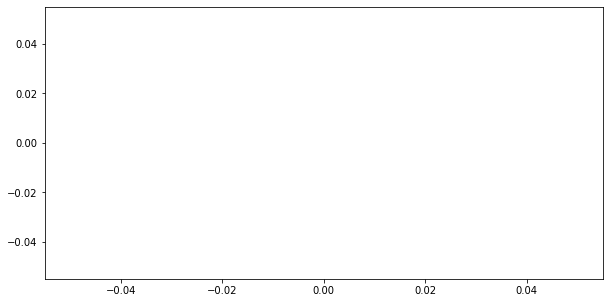

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses,'r')
plt.plot(val_losses, 'b')

## Set up the loaders and model for evaluation

In [51]:
dl_test = torch.utils.data.DataLoader(
    AgriDataset(df_val,
                means=means, stds=stds),
    shuffle=False, drop_last=False, batch_size=16, num_workers=2
    )

In [52]:
net.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pth')))
net.eval();

## Evaluate the model on the validation set

In [53]:
def evaluate(dl_test, net, crop_labels, df_val):
  field_data = []
  outputs = []
  with torch.no_grad():
    for imgs, gt, field_id in tqdm(dl_test):
      output = net(imgs.cuda()).softmax(-1).cpu().numpy()
      # output = output[:, np.int_(crop_labels)]
      field_id = field_id.numpy()
      field_data.append(field_id)
      outputs.append(output)
  outputs = np.concatenate(outputs, axis=0)
  outputs = outputs * df_val['field_area'].values.reshape(-1, 1)

  df_out = pd.DataFrame(outputs, columns=crop_labels)
  df_out['field_id'] = df_val['field_id']
  df_out['crop_type'] = df_val['crop_type']
  df_sm = df_out.groupby('field_id').sum().reset_index()
  probs = df_sm[crop_labels].values
  probs = probs / np.sum(probs, axis=1).reshape(-1,1)
  crop_types = df_out.groupby('field_id').mean().reset_index()['crop_type'].values
        
  return probs, np.int_(df_sm['field_id'].values), crop_types

In [54]:
probs, field_ids, gt = evaluate(dl_test, net, crop_labels, df_val)

100%|██████████| 73/73 [01:02<00:00,  1.16it/s]


In [55]:
probs.shape, field_ids.shape, gt.shape

((1112, 13), (1112,), (1112,))

In [56]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

print(classification_report(gt, np.array(crop_labels)[np.argmax(probs, axis=1)]))

              precision    recall  f1-score   support

         1.0       0.74      0.13      0.21       406
         2.0       0.39      0.04      0.06       198
         3.0       0.03      0.24      0.06        21
         4.0       0.89      0.44      0.59       328
         5.0       0.01      0.20      0.02         5
         6.0       0.13      0.61      0.21        33
         8.0       0.08      0.50      0.14        10
         9.0       0.53      0.88      0.66        59
        13.0       0.07      0.58      0.13        12
        14.0       0.06      0.67      0.11         3
        15.0       0.00      0.00      0.00         8
        16.0       0.00      0.00      0.00         3
        36.0       0.15      0.54      0.24        26

    accuracy                           0.28      1112
   macro avg       0.24      0.37      0.19      1112
weighted avg       0.64      0.28      0.31      1112



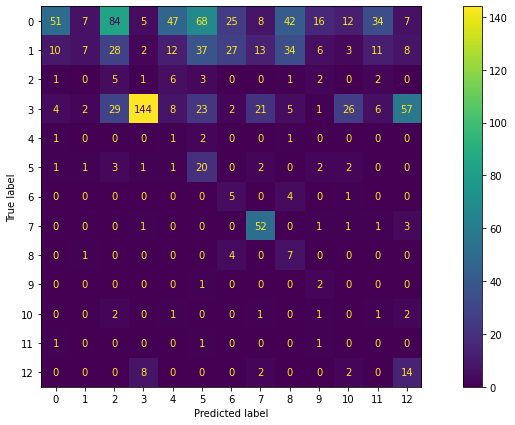

In [57]:
# Confusion matrix
cm = confusion_matrix(gt, np.array(crop_labels)[np.argmax(probs, axis=1)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

In [58]:
def to_one_hot(x):
    y = np.zeros((x.size, x.max() + 1))
    y[np.arange(x.size), x] = 1
    return y

def cross_entropy(predictions, targets):
    return -np.sum(np.sum(np.log(predictions + 10**(-10)) * targets, axis=1))/len(targets)


In [59]:
# targets = to_one_hot(np.int_([np.where(crop_labels == lb)[0][0] for lb in gt]))
targets = to_one_hot(np.int_(gt))
targets = targets[:, np.where(targets.sum(axis=0) > 0)[0]]

In [60]:
cross_entropy(probs, targets)

2.0126469357428105

## Prepare the test dataset

In [61]:
test_paths = os.listdir(os.path.join(data_dir, test_label_collection))
test_ids = [fn.split('_')[-1] for fn in test_paths if 'labels_test' in fn]

field_paths = [f'{data_dir}/{test_label_collection}/{test_label_collection}_{i}/field_ids.tif' 
               for i in test_ids]
label_paths = [f'{data_dir}/{test_label_collection}/{test_label_collection}_{i}/raster_labels.tif' 
               for i in test_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in test_ids]

In [62]:
test_data = pd.DataFrame(np.array([test_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
test_data.head()

,folder_id,field_path,label_path,source_path
0,865ac,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
1,2d6ad,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
2,5316d,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
3,57ee6,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
4,2326f,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...


In [63]:
def extract_field_crop_data_test(data):
  field_ids = []
  field_center_x = []
  field_center_y = []
  field_paths = []
  source_paths = []
  field_area = []

  for i in tqdm(range(len(data))):
      with rasterio.open(data['field_path'].iloc[i]) as src:
          field_data = src.read()[0]

      for field_id in np.unique(field_data)[1:]:
          ind = np.where(field_data == field_id)
          field_ids.append(field_id)
          field_area.append(len(ind[0]))
          field_center_y.append(np.mean(ind[0]))
          field_center_x.append(np.mean(ind[1]))
          field_paths.append(data['field_path'].iloc[i])
          source_paths.append(data['source_path'].iloc[i])

  df = pd.DataFrame(np.array([field_ids, field_center_x, 
                              field_center_y, field_area]).transpose(),
                    columns=['field_id', 'center_x', 'center_y', 'field_area'])
  df['field_path'] = field_paths
  df['source_path'] = source_paths
  return df

In [64]:
test_df = extract_field_crop_data_test(test_data)
test_df['crop_ind'] = 0
test_df['crop_type'] = 1

100%|██████████| 707/707 [00:02<00:00, 250.13it/s]


## Evaluate the model on the test set

In [67]:
dl_test = torch.utils.data.DataLoader(
    AgriDataset(test_df,
                means=means, stds=stds), shuffle=False, drop_last=False, 
    batch_size=16, num_workers=2
    )

In [68]:
probs, field_ids, _ = evaluate(dl_test, net, crop_labels, test_df)

100%|██████████| 101/101 [01:28<00:00,  1.14it/s]


In [69]:
crop_columns = [crop_dict[key] for key in crop_labels]

output_df = pd.DataFrame(columns=['field_id'] + crop_columns)

output_df['field_id'] = field_ids

output_df[crop_columns] = probs 
output_df.to_csv('submission.csv', index=False)
output_df.to_csv(os.path.join(model_dir, 'predictions.csv'), index=False)

In [70]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>